In [1]:
import pandas as pd
import subprocess
from tqdm import tqdm 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', 100)
%load_ext watermark
%watermark -a "Florian Tesson" -d -v -p pandas,numpy,matplotlib,seaborn

Author: Florian Tesson

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.2.0

pandas    : 1.4.0
numpy     : 1.24.4
matplotlib: 3.8.3
seaborn   : 0.13.2



In [26]:
anti=pd.read_table('data/threshold/SuppTable1_first_detection.tsv',sep='\t')


clusters=pd.read_table('data/threshold/Clusters_first_detection_accession.tsv',sep='\t')

anti["hit_id_short"]=anti.hit_id.map(lambda x: x.replace('lcl|',''))
anti=anti.merge(clusters,on=['gene_name','hit_id_short'],how='left')#.drop(columns=['hit_id_short'])

list_sys=anti.gene_name.unique()

In [28]:
orig_detect=pd.read_table('data/threshold/Results_original_protein.tsv',delim_whitespace=True,comment='#',
                          names=['hit_id','X1','hit_id_len','gene_name','X2','gene_name_len','evlalue','hit_score','bias1','id_domain','Nb_domain','evalue_dom','ivalue_dom','hit_score_dom','bias_dom','gene_name_start','gene_name_end',
                                                                         'hit_id_start','hit_id_end','hit_id_env_start','hit_id_env_end','X3','strand'])
orig_detect=orig_detect.loc[orig_detect.gene_name==orig_detect.hit_id]
orig_detect['hit_profile_cov']=(orig_detect.gene_name_end-orig_detect.gene_name_start+1)/(orig_detect.gene_name_len)
orig_detect['hit_seq_cov']=(orig_detect.hit_id_end-orig_detect.hit_id_start+1)/(orig_detect.hit_id_len)

ga=pd.read_table('data/threshold/GA_cut_profiles.tsv',sep=' ',names=['gene_name','GA_cut'])
ga=pd.concat([ga,pd.DataFrame({'gene_name':['tad2','hia5'],'GA_cut':[75,200]})])
ga['gene_name']=ga.gene_name.map(lambda x: x.replace('_sequences','').lower())
ga=ga.reset_index(drop=True)
ga['GA_cut']=ga.GA_cut.map(float)


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.61it/s]


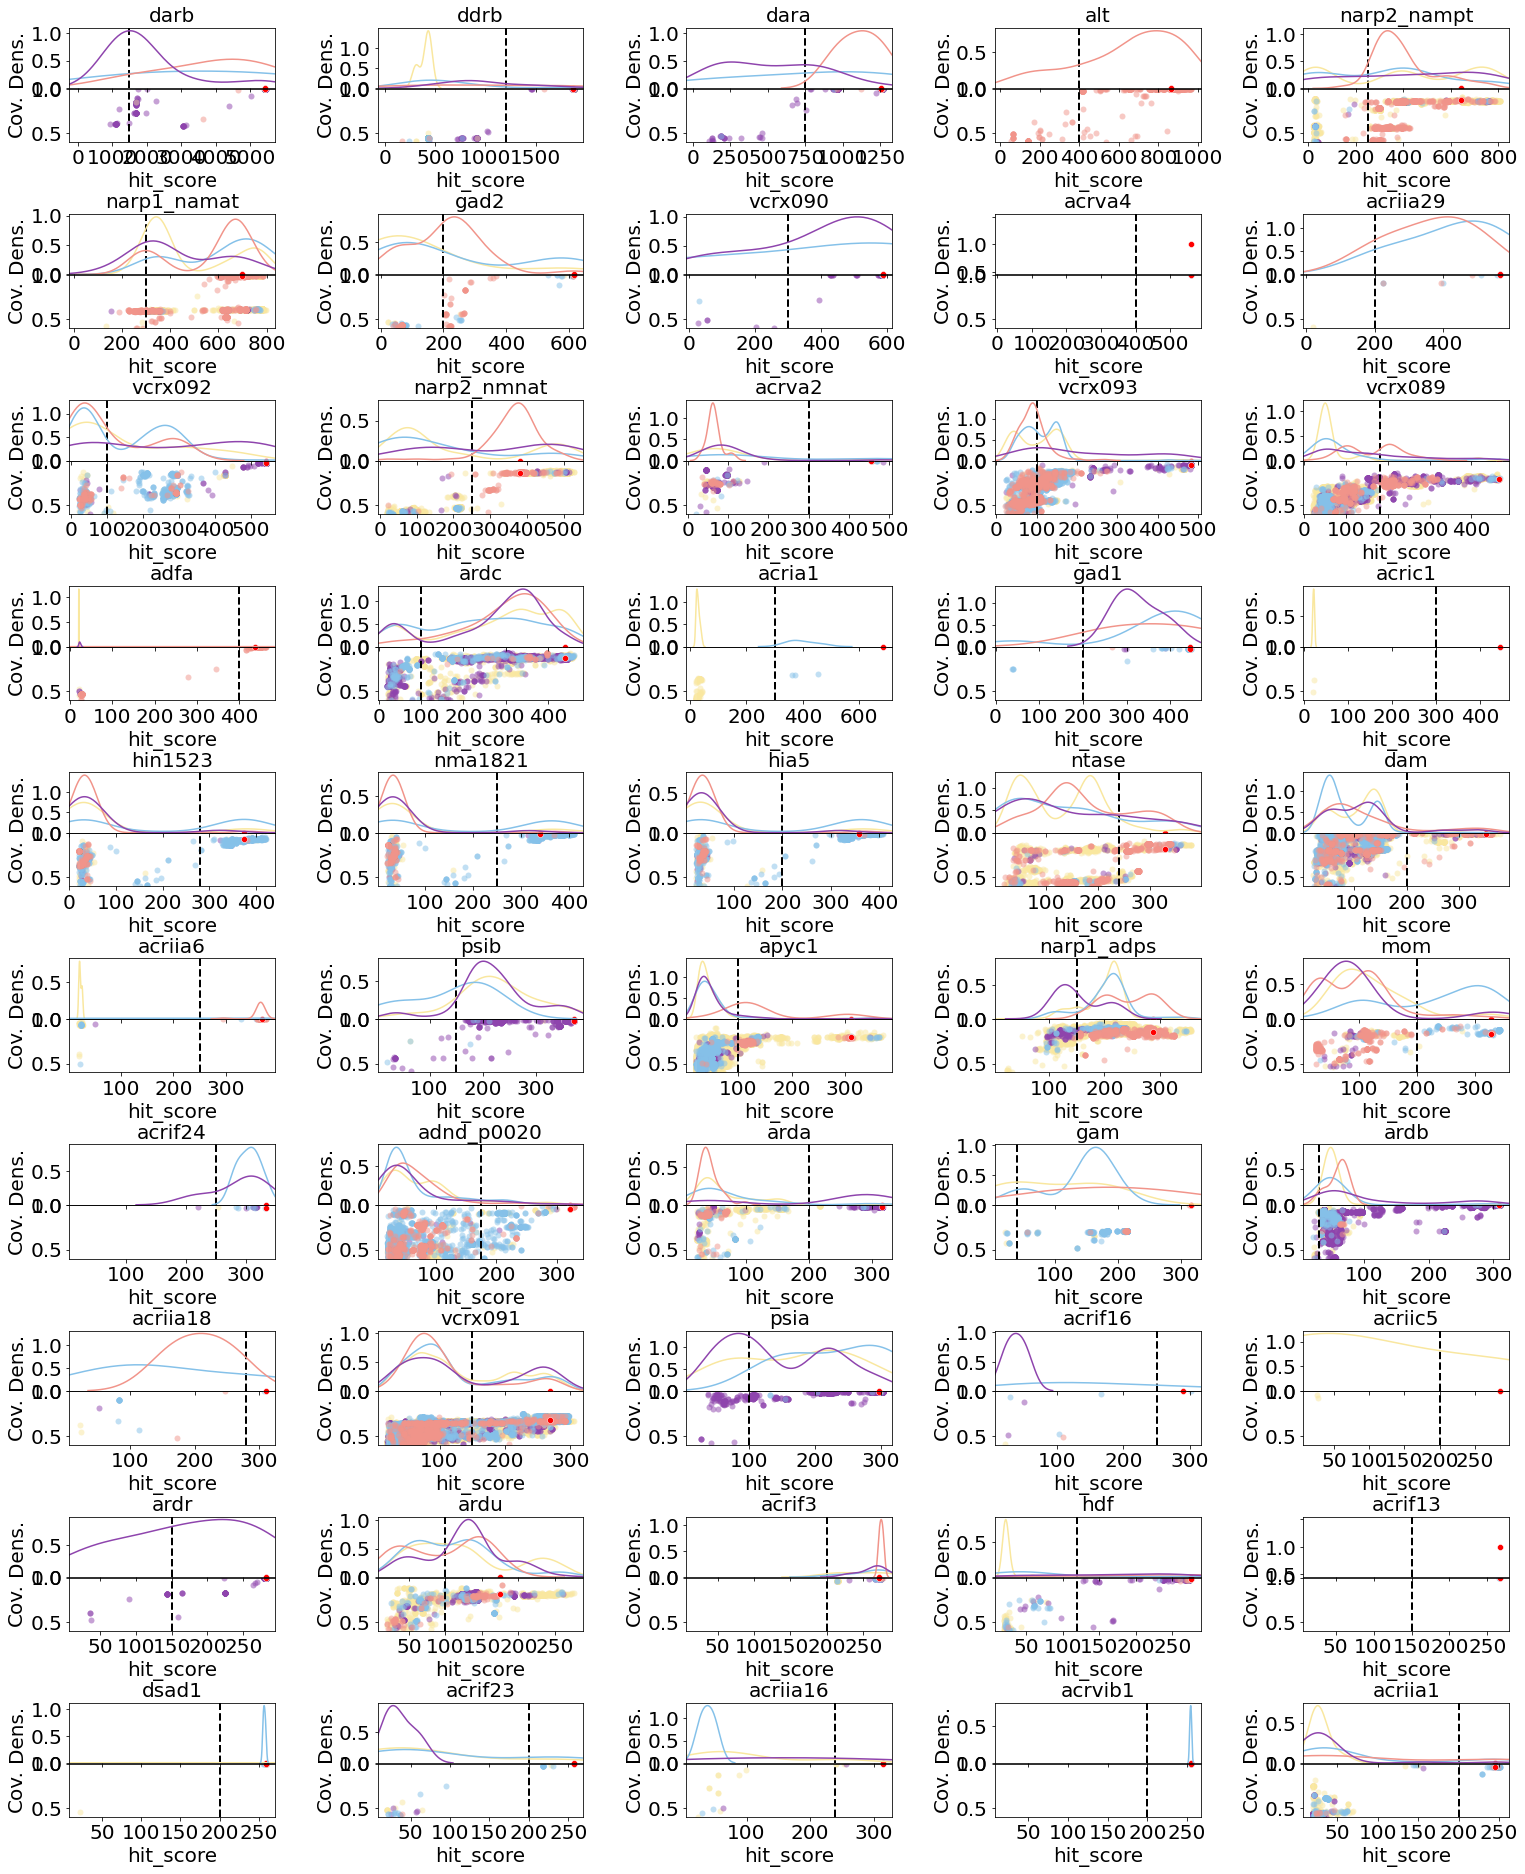

In [29]:
import warnings
warnings.filterwarnings("ignore")

fig,ax=plt.subplots(10,5,figsize=(25,60))

plt.rcParams['pdf.fonttype'] = 42
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    hspace=2.5,top=0.5,
                   wspace=.5)
dist_ax = np.empty_like(ax)

for i in tqdm(range(0,50)):
    system=list_sys[i+0]
    col=i%5
    row=i//5
    tmp=anti.loc[anti.gene_name==system]
    
    ax[row,col].vlines(x=ga.loc[ga.gene_name==system,'GA_cut'].to_list(),ymin=0.4,ymax=1,color="black",linestyle="dashed",linewidth=2)
    ax[row,col].vlines(x=[20],ymin=0.4,ymax=1,color="white",alpha=0.1)
    sns.scatterplot(ax=ax[row,col],x=tmp.loc[tmp.Localisation=='Not_MGE'].hit_score,y=tmp.loc[tmp.Localisation=='Not_MGE'].hit_profile_cov,color="#F9E79F",alpha=0.5, linewidth=0,rasterized=True)
    sns.scatterplot(ax=ax[row,col],x=tmp.loc[tmp.Localisation=='Plasmid'].hit_score,y=tmp.loc[tmp.Localisation=='Plasmid'].hit_profile_cov,color="#8E44AD",alpha=0.5, linewidth=0,rasterized=True)
    sns.scatterplot(ax=ax[row,col],x=tmp.loc[tmp.Localisation=='Prophage'].hit_score,y=tmp.loc[tmp.Localisation=='Prophage'].hit_profile_cov,color="#85C1E9",alpha=0.5, linewidth=0,rasterized=True)
    sns.scatterplot(ax=ax[row,col],x=tmp.loc[tmp.Localisation=='Phage'].hit_score,y=tmp.loc[tmp.Localisation=='Phage'].hit_profile_cov,color="#F1948A",alpha=0.5, linewidth=0,rasterized=True)
    sns.scatterplot(ax=ax[row,col],x=orig_detect.loc[orig_detect.gene_name==system].hit_score,y=orig_detect.loc[orig_detect.gene_name==system].hit_profile_cov,color='red')
    
    ax[row,col].set_xticklabels(ax[row,col].get_xticklabels(),fontsize=20)
    ax[row,col].set_yticklabels(ax[row,col].get_yticklabels(),fontsize=20)
    ax[row,col].set_xlabel('hit_score',fontsize=20)
    ax[row,col].set_ylabel('Cov.',fontsize=20)

    pad = 0.0001 # adjust
    height = 0.07/5# adjust
    box = ax[row][col].get_position() # coordonnée de l'axe
    dist_ax[row][col] = fig.add_axes([box.xmin, box.ymax+pad, box.width, height], zorder=10)
    dist_ax[row][col].set_yticklabels(dist_ax[row][col].get_yticklabels(),fontsize=20)
    dist_ax[row][col].set_ylabel("Dens.",fontsize=20)

    try:
        sns.scatterplot(ax=dist_ax[row][col],x=orig_detect.loc[orig_detect.gene_name==system].hit_score,y=[0],color='red')
    except:
        pass
    dist_ax[row,col].axvline(x=ga.loc[ga.gene_name==system,'GA_cut'].to_list()[0],ymin=0,ymax=1,color="black",linestyle="dashed",linewidth=2)
    dist_ax[row,col].axvline(x=20,ymin=0,ymax=1,color="white",alpha=0,linewidth=.5)
    try:
        
        # tmp.loc[tmp.in_prophage==0].hit_score.plot(kind="kde", ax=dist_ax[row][col],color="#F9E79F")
        sns.kdeplot(tmp.loc[tmp.Localisation=='Not_MGE'].drop_duplicates('Cluster').hit_score,ax=dist_ax[row][col],color="#F9E79F")
    except (np.linalg.LinAlgError, ValueError):
        pass
    try:
        # tmp.loc[tmp.in_prophage==1].hit_score.plot(kind="kde", ax=dist_ax[row][col],color="#85C1E9")
        sns.kdeplot(tmp.loc[tmp.Localisation=='Prophage'].drop_duplicates('Cluster').hit_score,ax=dist_ax[row][col],color="#85C1E9")

    except (np.linalg.LinAlgError, ValueError):
        pass
    try:
        # tmp.loc[tmp.in_prophage==2].hit_score.plot(kind="kde", ax=dist_ax[row][col],color="#F1948A")
        sns.kdeplot(tmp.loc[tmp.Localisation=='Phage'].drop_duplicates('Cluster').hit_score,ax=dist_ax[row][col],color="#F1948A")

    except (np.linalg.LinAlgError, ValueError):
        pass
    try:
        # tmp.loc[tmp.in_prophage==3].hit_score.plot(kind="kde", ax=dist_ax[row][col],color="#8E44AD")
        sns.kdeplot(tmp.loc[tmp.Localisation=='Plasmid'].drop_duplicates('Cluster').hit_score,ax=dist_ax[row][col],color="#8E44AD")

    except (np.linalg.LinAlgError, ValueError):
        pass

    ax[row,col].set_xlabel('hit_score')
    dist_ax[row][col].set_title(system,size=20)
    dist_ax[row, col].set_xlabel("", visible=False)
    dist_ax[row, col].set_xlim(*ax[row, col].get_xlim())
    dist_ax[row, col].set_xticklabels("", visible=False)

    ax[row,col].set_ylim(0.4,1)
    


plt.savefig('results/threshold/Treshold_results_group1.pdf',format='pdf',bbox_inches='tight')
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.72it/s]


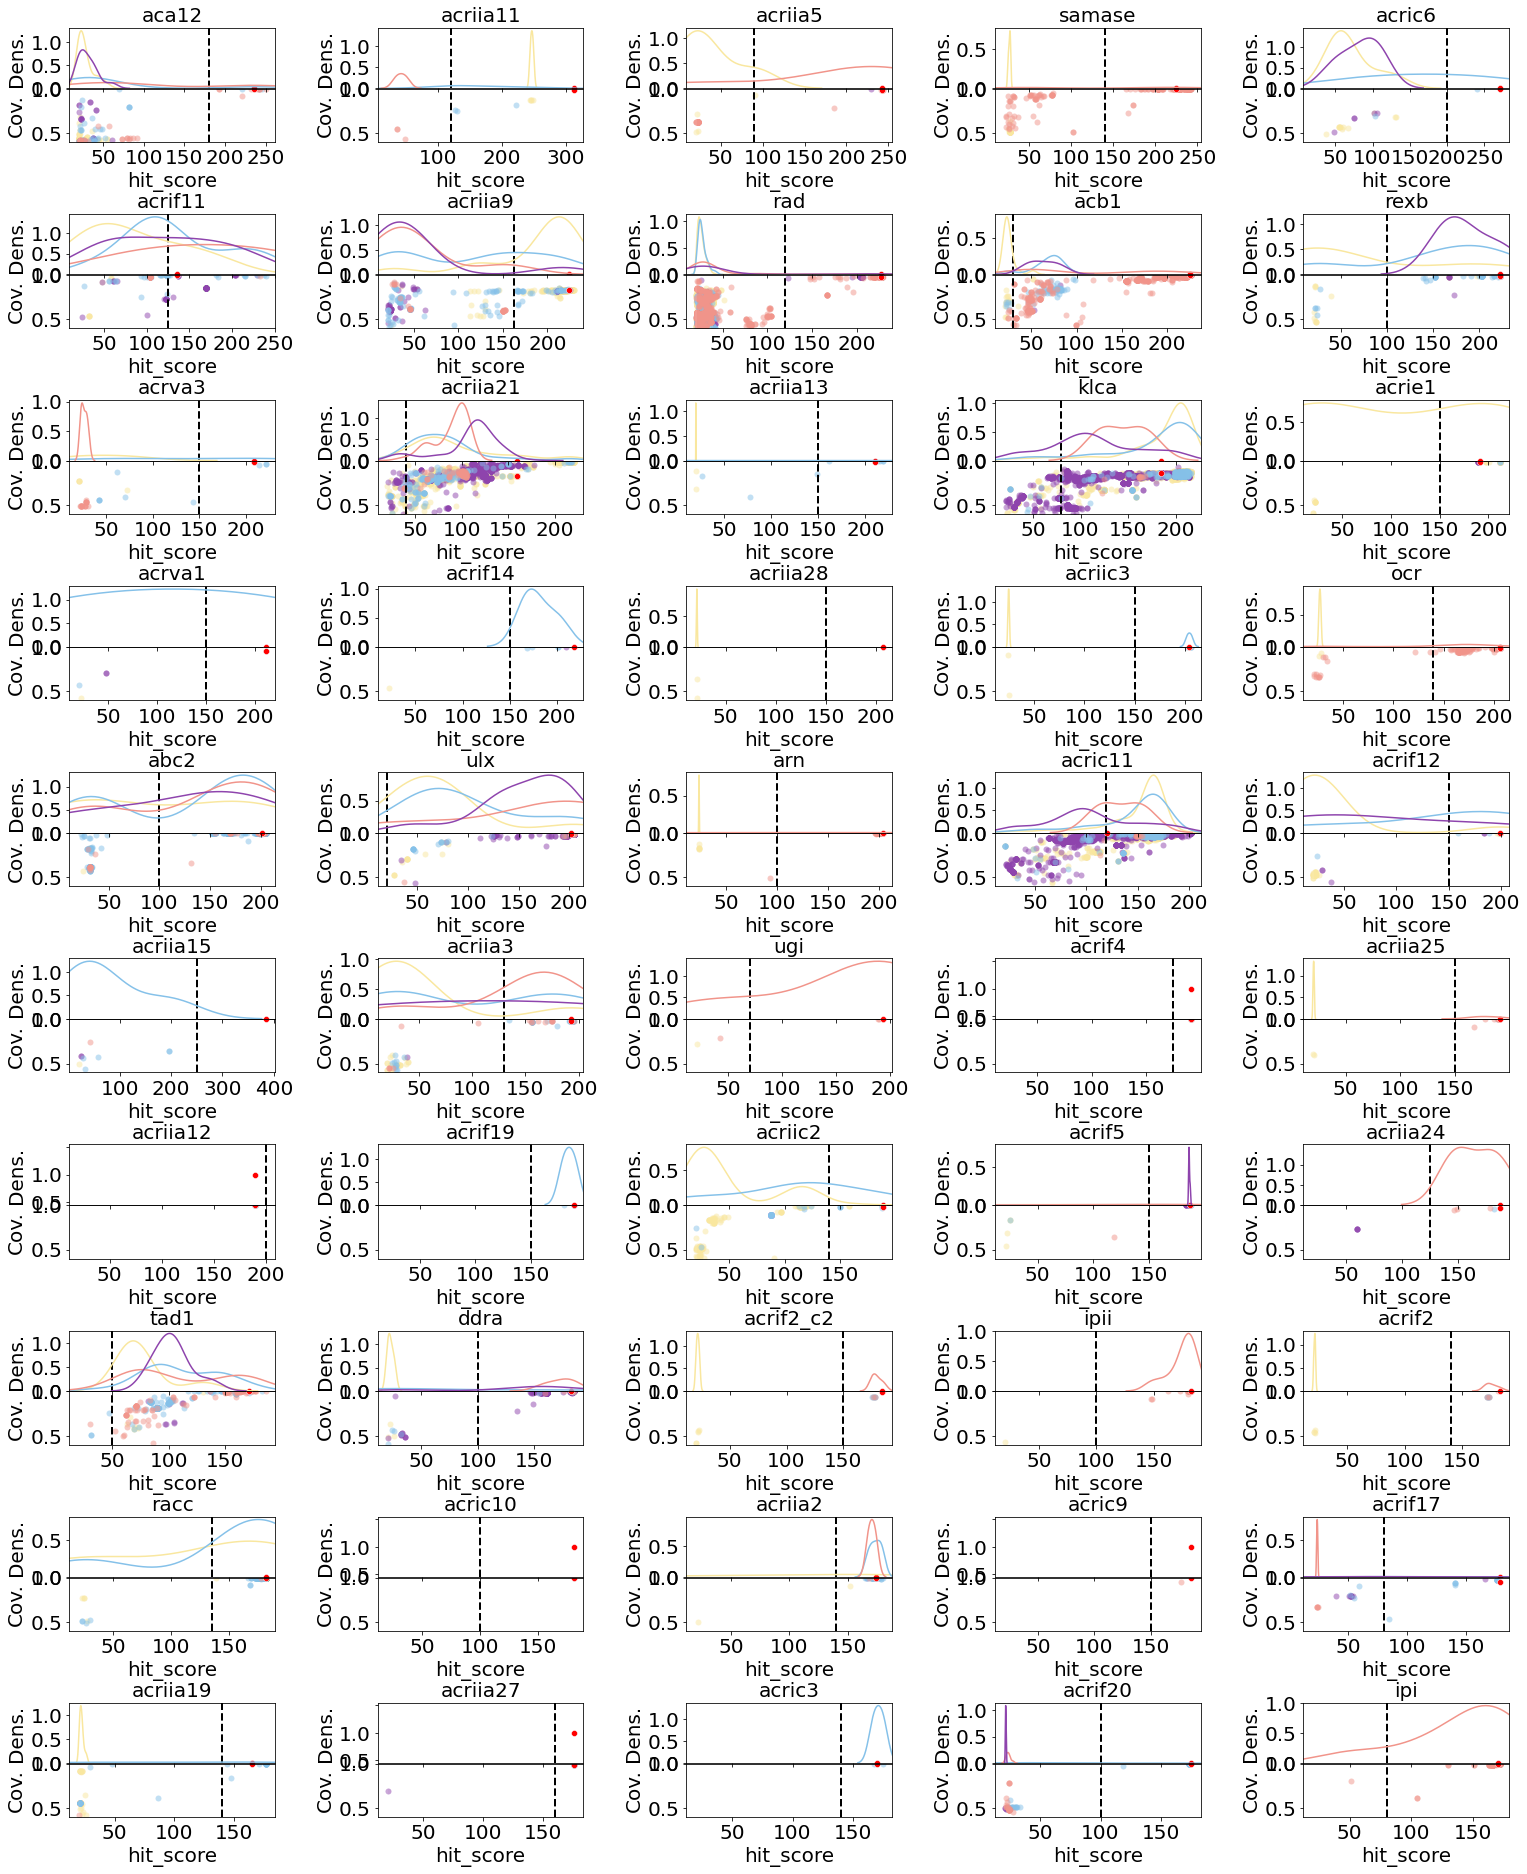

In [22]:
import warnings
warnings.filterwarnings("ignore")

fig,ax=plt.subplots(10,5,figsize=(25,60))

plt.rcParams['pdf.fonttype'] = 42
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    hspace=2.5,top=0.5,
                   wspace=.5)
dist_ax = np.empty_like(ax)

for i in tqdm(range(0,50)):
    system=list_sys[i+50]
    col=i%5
    row=i//5
    tmp=anti.loc[anti.gene_name==system]
    
    ax[row,col].vlines(x=ga.loc[ga.gene_name==system,'GA_cut'].to_list(),ymin=0.4,ymax=1,color="black",linestyle="dashed",linewidth=2)
    ax[row,col].vlines(x=[20],ymin=0.4,ymax=1,color="white",alpha=0.1)
    sns.scatterplot(ax=ax[row,col],x=tmp.loc[tmp.Localisation=='Not_MGE'].hit_score,y=tmp.loc[tmp.Localisation=='Not_MGE'].hit_profile_cov,color="#F9E79F",alpha=0.5, linewidth=0,rasterized=True)
    sns.scatterplot(ax=ax[row,col],x=tmp.loc[tmp.Localisation=='Plasmid'].hit_score,y=tmp.loc[tmp.Localisation=='Plasmid'].hit_profile_cov,color="#8E44AD",alpha=0.5, linewidth=0,rasterized=True)
    sns.scatterplot(ax=ax[row,col],x=tmp.loc[tmp.Localisation=='Prophage'].hit_score,y=tmp.loc[tmp.Localisation=='Prophage'].hit_profile_cov,color="#85C1E9",alpha=0.5, linewidth=0,rasterized=True)
    sns.scatterplot(ax=ax[row,col],x=tmp.loc[tmp.Localisation=='Phage'].hit_score,y=tmp.loc[tmp.Localisation=='Phage'].hit_profile_cov,color="#F1948A",alpha=0.5, linewidth=0,rasterized=True)
    sns.scatterplot(ax=ax[row,col],x=orig_detect.loc[orig_detect.gene_name==system].hit_score,y=orig_detect.loc[orig_detect.gene_name==system].hit_profile_cov,color='red')
    
    ax[row,col].set_xticklabels(ax[row,col].get_xticklabels(),fontsize=20)
    ax[row,col].set_yticklabels(ax[row,col].get_yticklabels(),fontsize=20)
    ax[row,col].set_xlabel('hit_score',fontsize=20)
    ax[row,col].set_ylabel('Cov.',fontsize=20)

    pad = 0.0001 # adjust
    height = 0.07/5# adjust
    box = ax[row][col].get_position() # coordonnée de l'axe
    dist_ax[row][col] = fig.add_axes([box.xmin, box.ymax+pad, box.width, height], zorder=10)
    dist_ax[row][col].set_yticklabels(dist_ax[row][col].get_yticklabels(),fontsize=20)
    dist_ax[row][col].set_ylabel("Dens.",fontsize=20)

    try:
        sns.scatterplot(ax=dist_ax[row][col],x=orig_detect.loc[orig_detect.gene_name==system].hit_score,y=[0],color='red')
    except:
        pass
    dist_ax[row,col].axvline(x=ga.loc[ga.gene_name==system,'GA_cut'].to_list()[0],ymin=0,ymax=1,color="black",linestyle="dashed",linewidth=2)
    dist_ax[row,col].axvline(x=20,ymin=0,ymax=1,color="white",alpha=0,linewidth=.5)
    try:
        
        # tmp.loc[tmp.in_prophage==0].hit_score.plot(kind="kde", ax=dist_ax[row][col],color="#F9E79F")
        sns.kdeplot(tmp.loc[tmp.Localisation=='Not_MGE'].drop_duplicates('Cluster').hit_score,ax=dist_ax[row][col],color="#F9E79F")
    except (np.linalg.LinAlgError, ValueError):
        pass
    try:
        # tmp.loc[tmp.in_prophage==1].hit_score.plot(kind="kde", ax=dist_ax[row][col],color="#85C1E9")
        sns.kdeplot(tmp.loc[tmp.Localisation=='Prophage'].drop_duplicates('Cluster').hit_score,ax=dist_ax[row][col],color="#85C1E9")

    except (np.linalg.LinAlgError, ValueError):
        pass
    try:
        # tmp.loc[tmp.in_prophage==2].hit_score.plot(kind="kde", ax=dist_ax[row][col],color="#F1948A")
        sns.kdeplot(tmp.loc[tmp.Localisation=='Phage'].drop_duplicates('Cluster').hit_score,ax=dist_ax[row][col],color="#F1948A")

    except (np.linalg.LinAlgError, ValueError):
        pass
    try:
        # tmp.loc[tmp.in_prophage==3].hit_score.plot(kind="kde", ax=dist_ax[row][col],color="#8E44AD")
        sns.kdeplot(tmp.loc[tmp.Localisation=='Plasmid'].drop_duplicates('Cluster').hit_score,ax=dist_ax[row][col],color="#8E44AD")

    except (np.linalg.LinAlgError, ValueError):
        pass

    ax[row,col].set_xlabel('hit_score')
    dist_ax[row][col].set_title(system,size=20)
    dist_ax[row, col].set_xlabel("", visible=False)
    dist_ax[row, col].set_xlim(*ax[row, col].get_xlim())
    dist_ax[row, col].set_xticklabels("", visible=False)

    ax[row,col].set_ylim(0.4,1)
    


plt.savefig('results/threshold/Treshold_results_group2.pdf',format='pdf',bbox_inches='tight')
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.32it/s]


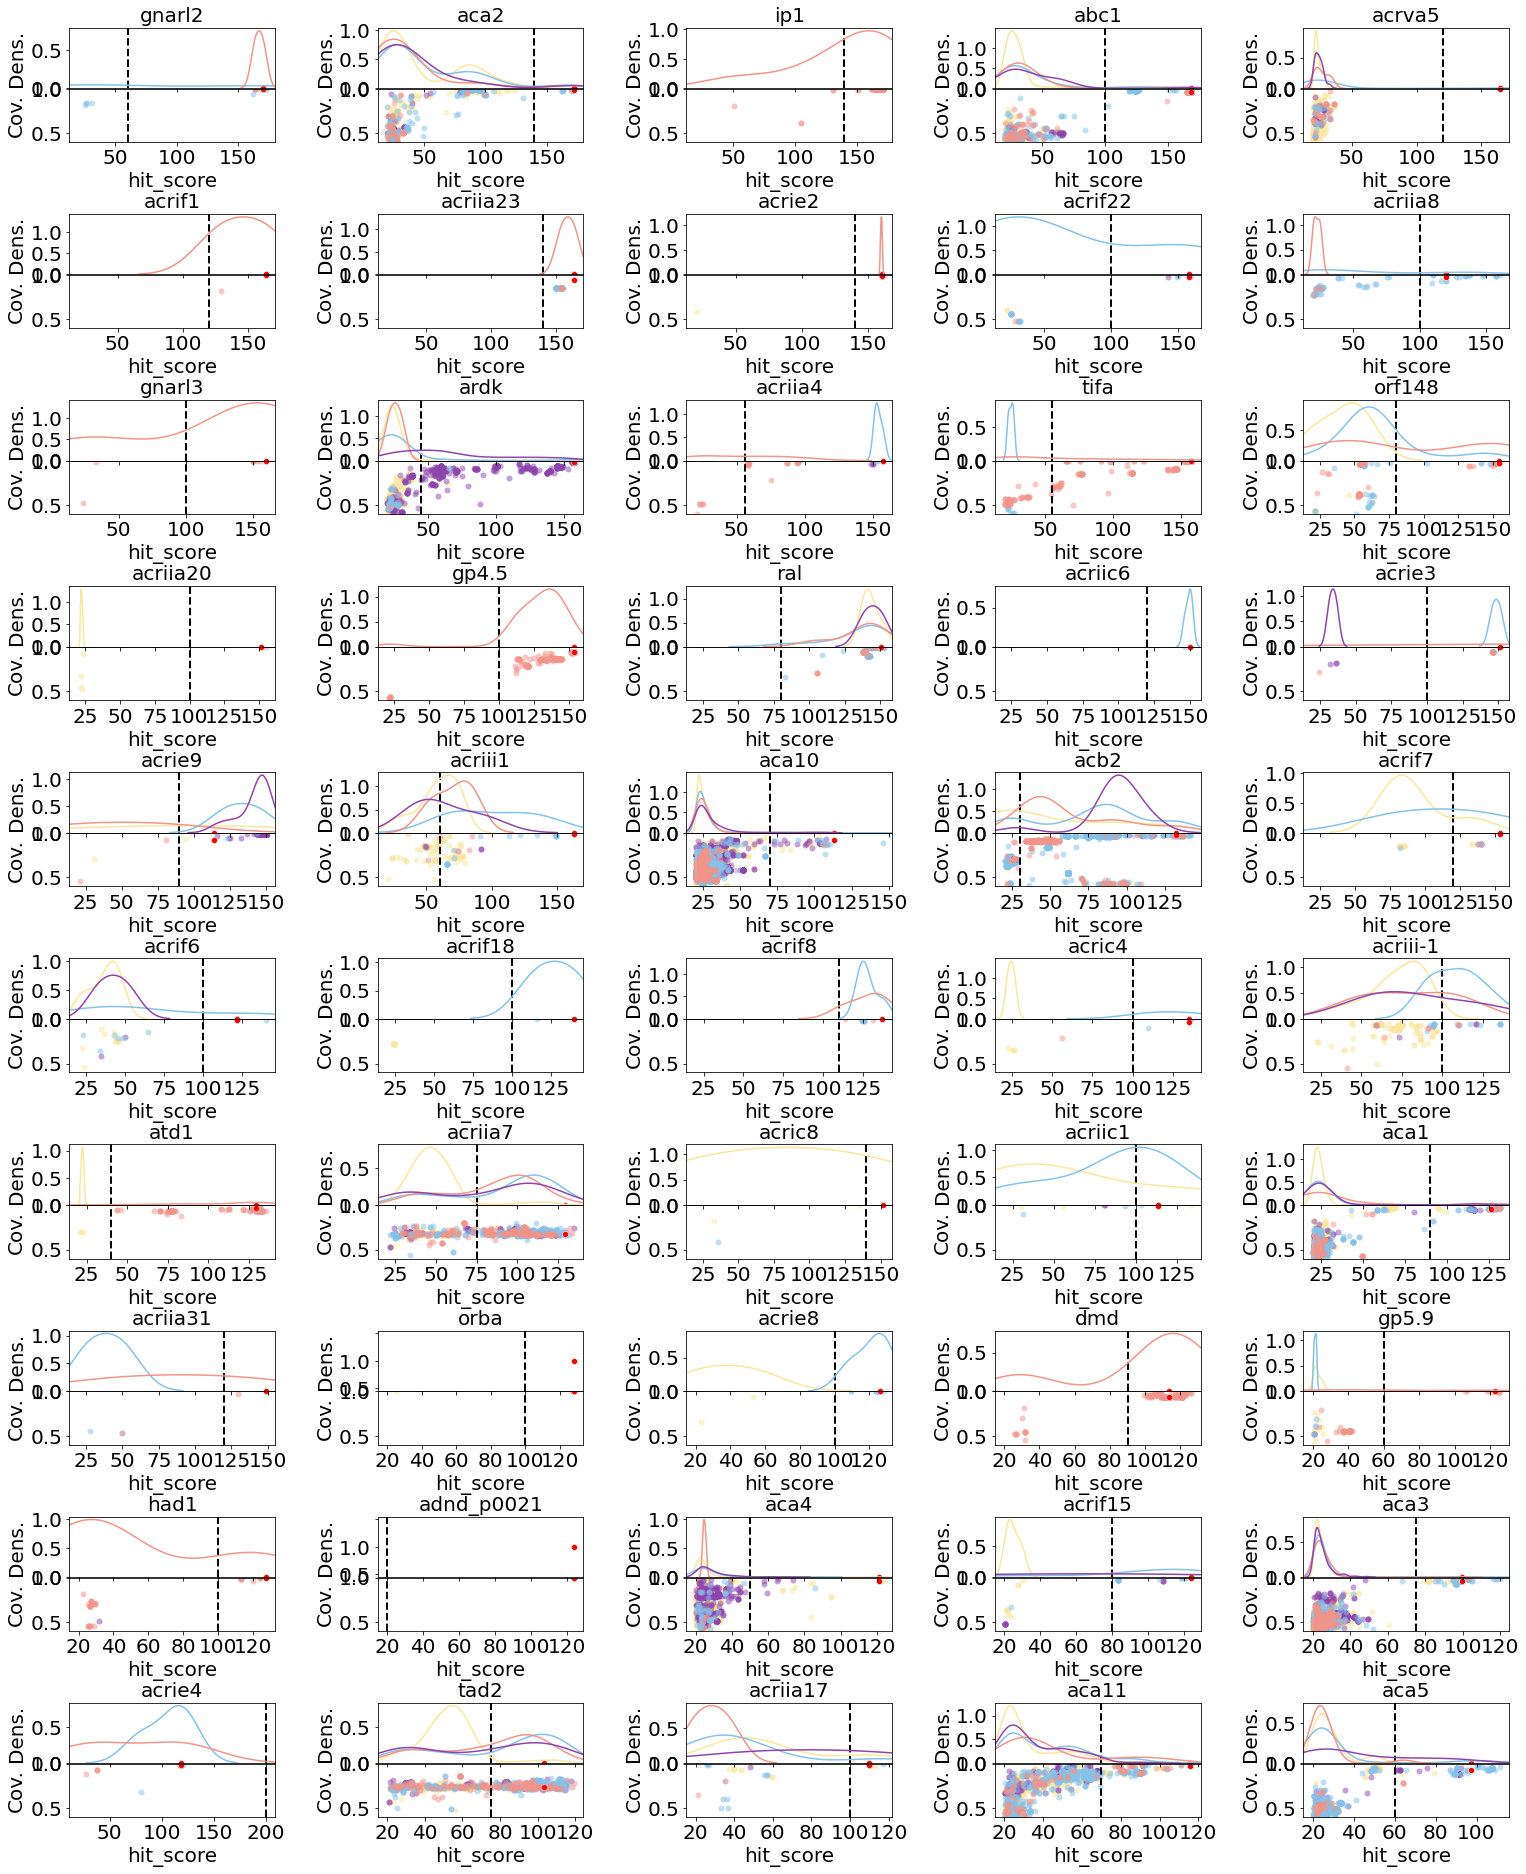

In [23]:
import warnings
warnings.filterwarnings("ignore")

fig,ax=plt.subplots(10,5,figsize=(25,60))

plt.rcParams['pdf.fonttype'] = 42
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    hspace=2.5,top=0.5,
                   wspace=.5)
dist_ax = np.empty_like(ax)

for i in tqdm(range(0,50)):
    system=list_sys[i+100]
    col=i%5
    row=i//5
    tmp=anti.loc[anti.gene_name==system]
    
    ax[row,col].vlines(x=ga.loc[ga.gene_name==system,'GA_cut'].to_list(),ymin=0.4,ymax=1,color="black",linestyle="dashed",linewidth=2)
    ax[row,col].vlines(x=[20],ymin=0.4,ymax=1,color="white",alpha=0.1)
    sns.scatterplot(ax=ax[row,col],x=tmp.loc[tmp.Localisation=='Not_MGE'].hit_score,y=tmp.loc[tmp.Localisation=='Not_MGE'].hit_profile_cov,color="#F9E79F",alpha=0.5, linewidth=0,rasterized=True)
    sns.scatterplot(ax=ax[row,col],x=tmp.loc[tmp.Localisation=='Plasmid'].hit_score,y=tmp.loc[tmp.Localisation=='Plasmid'].hit_profile_cov,color="#8E44AD",alpha=0.5, linewidth=0,rasterized=True)
    sns.scatterplot(ax=ax[row,col],x=tmp.loc[tmp.Localisation=='Prophage'].hit_score,y=tmp.loc[tmp.Localisation=='Prophage'].hit_profile_cov,color="#85C1E9",alpha=0.5, linewidth=0,rasterized=True)
    sns.scatterplot(ax=ax[row,col],x=tmp.loc[tmp.Localisation=='Phage'].hit_score,y=tmp.loc[tmp.Localisation=='Phage'].hit_profile_cov,color="#F1948A",alpha=0.5, linewidth=0,rasterized=True)
    sns.scatterplot(ax=ax[row,col],x=orig_detect.loc[orig_detect.gene_name==system].hit_score,y=orig_detect.loc[orig_detect.gene_name==system].hit_profile_cov,color='red')
    
    ax[row,col].set_xticklabels(ax[row,col].get_xticklabels(),fontsize=20)
    ax[row,col].set_yticklabels(ax[row,col].get_yticklabels(),fontsize=20)
    ax[row,col].set_xlabel('hit_score',fontsize=20)
    ax[row,col].set_ylabel('Cov.',fontsize=20)

    pad = 0.0001 # adjust
    height = 0.07/5# adjust
    box = ax[row][col].get_position() # coordonnée de l'axe
    dist_ax[row][col] = fig.add_axes([box.xmin, box.ymax+pad, box.width, height], zorder=10)
    dist_ax[row][col].set_yticklabels(dist_ax[row][col].get_yticklabels(),fontsize=20)
    dist_ax[row][col].set_ylabel("Dens.",fontsize=20)

    try:
        sns.scatterplot(ax=dist_ax[row][col],x=orig_detect.loc[orig_detect.gene_name==system].hit_score,y=[0],color='red')
    except:
        pass
    dist_ax[row,col].axvline(x=ga.loc[ga.gene_name==system,'GA_cut'].to_list()[0],ymin=0,ymax=1,color="black",linestyle="dashed",linewidth=2)
    dist_ax[row,col].axvline(x=20,ymin=0,ymax=1,color="white",alpha=0,linewidth=.5)
    try:
        
        # tmp.loc[tmp.in_prophage==0].hit_score.plot(kind="kde", ax=dist_ax[row][col],color="#F9E79F")
        sns.kdeplot(tmp.loc[tmp.Localisation=='Not_MGE'].drop_duplicates('Cluster').hit_score,ax=dist_ax[row][col],color="#F9E79F")
    except (np.linalg.LinAlgError, ValueError):
        pass
    try:
        # tmp.loc[tmp.in_prophage==1].hit_score.plot(kind="kde", ax=dist_ax[row][col],color="#85C1E9")
        sns.kdeplot(tmp.loc[tmp.Localisation=='Prophage'].drop_duplicates('Cluster').hit_score,ax=dist_ax[row][col],color="#85C1E9")

    except (np.linalg.LinAlgError, ValueError):
        pass
    try:
        # tmp.loc[tmp.in_prophage==2].hit_score.plot(kind="kde", ax=dist_ax[row][col],color="#F1948A")
        sns.kdeplot(tmp.loc[tmp.Localisation=='Phage'].drop_duplicates('Cluster').hit_score,ax=dist_ax[row][col],color="#F1948A")

    except (np.linalg.LinAlgError, ValueError):
        pass
    try:
        # tmp.loc[tmp.in_prophage==3].hit_score.plot(kind="kde", ax=dist_ax[row][col],color="#8E44AD")
        sns.kdeplot(tmp.loc[tmp.Localisation=='Plasmid'].drop_duplicates('Cluster').hit_score,ax=dist_ax[row][col],color="#8E44AD")

    except (np.linalg.LinAlgError, ValueError):
        pass

    ax[row,col].set_xlabel('hit_score')
    dist_ax[row][col].set_title(system,size=20)
    dist_ax[row, col].set_xlabel("", visible=False)
    dist_ax[row, col].set_xlim(*ax[row, col].get_xlim())
    dist_ax[row, col].set_xticklabels("", visible=False)

    ax[row,col].set_ylim(0.4,1)
    


plt.savefig('results/threshold/Treshold_results_group3.pdf',format='pdf',bbox_inches='tight')
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████| 22/22 [00:04<00:00,  4.48it/s]


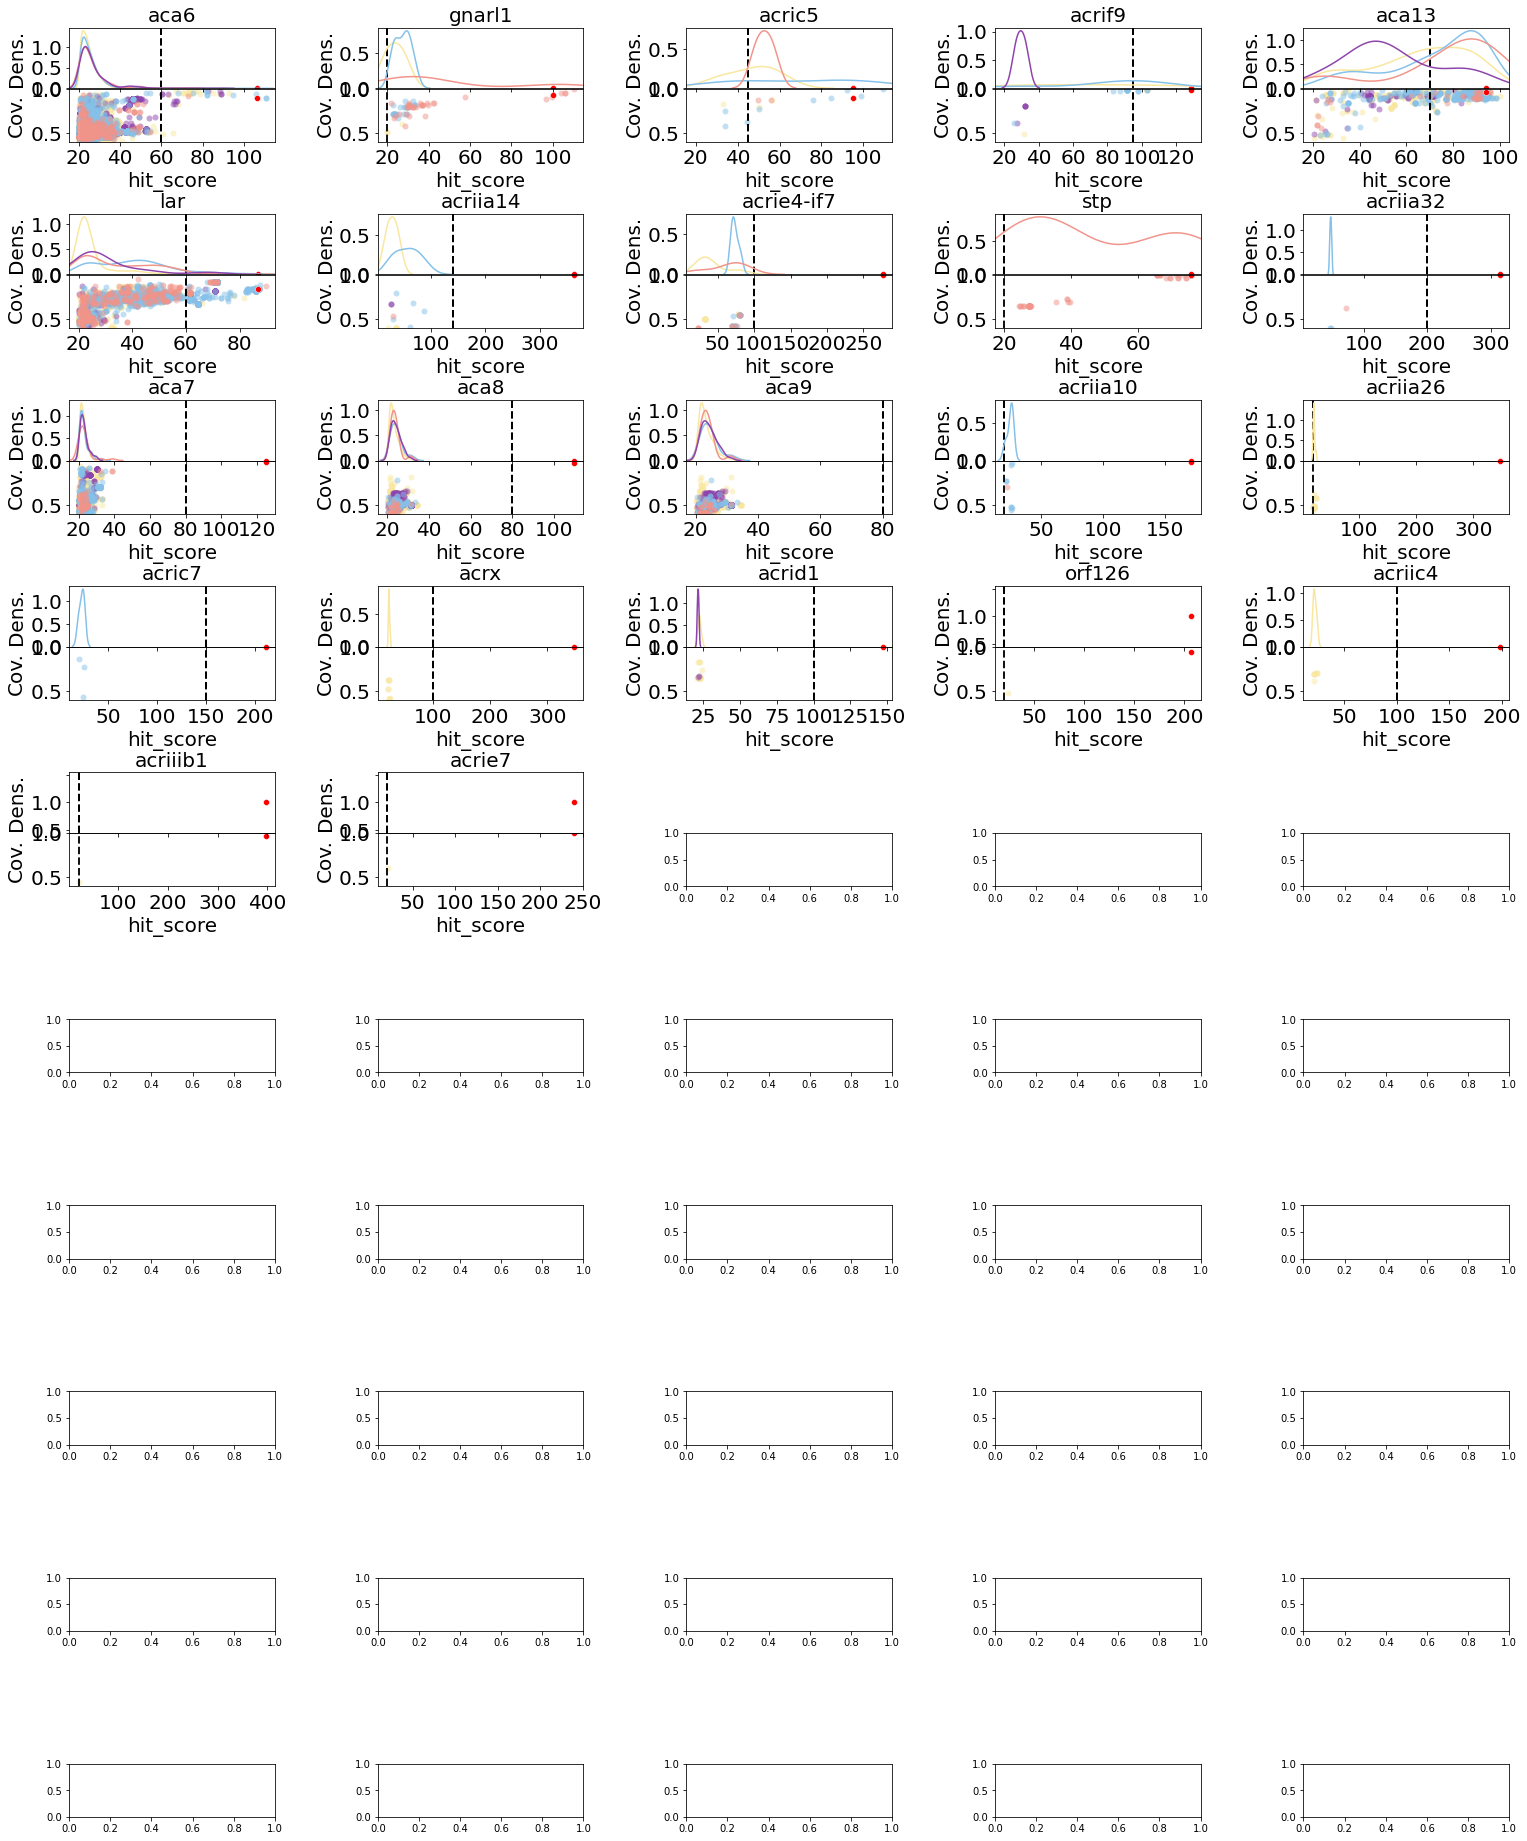

In [30]:
import warnings
warnings.filterwarnings("ignore")

fig,ax=plt.subplots(10,5,figsize=(25,60))

plt.rcParams['pdf.fonttype'] = 42
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    hspace=2.5,top=0.5,
                   wspace=.5)
dist_ax = np.empty_like(ax)

for i in tqdm(range(0,22)):
    system=list_sys[i+150]
    col=i%5
    row=i//5
    tmp=anti.loc[anti.gene_name==system]
    
    ax[row,col].vlines(x=ga.loc[ga.gene_name==system,'GA_cut'].to_list(),ymin=0.4,ymax=1,color="black",linestyle="dashed",linewidth=2)
    ax[row,col].vlines(x=[20],ymin=0.4,ymax=1,color="white",alpha=0.1)
    sns.scatterplot(ax=ax[row,col],x=tmp.loc[tmp.Localisation=='Not_MGE'].hit_score,y=tmp.loc[tmp.Localisation=='Not_MGE'].hit_profile_cov,color="#F9E79F",alpha=0.5, linewidth=0,rasterized=True)
    sns.scatterplot(ax=ax[row,col],x=tmp.loc[tmp.Localisation=='Plasmid'].hit_score,y=tmp.loc[tmp.Localisation=='Plasmid'].hit_profile_cov,color="#8E44AD",alpha=0.5, linewidth=0,rasterized=True)
    sns.scatterplot(ax=ax[row,col],x=tmp.loc[tmp.Localisation=='Prophage'].hit_score,y=tmp.loc[tmp.Localisation=='Prophage'].hit_profile_cov,color="#85C1E9",alpha=0.5, linewidth=0,rasterized=True)
    sns.scatterplot(ax=ax[row,col],x=tmp.loc[tmp.Localisation=='Phage'].hit_score,y=tmp.loc[tmp.Localisation=='Phage'].hit_profile_cov,color="#F1948A",alpha=0.5, linewidth=0,rasterized=True)
    sns.scatterplot(ax=ax[row,col],x=orig_detect.loc[orig_detect.gene_name==system].hit_score,y=orig_detect.loc[orig_detect.gene_name==system].hit_profile_cov,color='red')
    
    ax[row,col].set_xticklabels(ax[row,col].get_xticklabels(),fontsize=20)
    ax[row,col].set_yticklabels(ax[row,col].get_yticklabels(),fontsize=20)
    ax[row,col].set_xlabel('hit_score',fontsize=20)
    ax[row,col].set_ylabel('Cov.',fontsize=20)

    pad = 0.0001 # adjust
    height = 0.07/5# adjust
    box = ax[row][col].get_position() # coordonnée de l'axe
    dist_ax[row][col] = fig.add_axes([box.xmin, box.ymax+pad, box.width, height], zorder=10)
    dist_ax[row][col].set_yticklabels(dist_ax[row][col].get_yticklabels(),fontsize=20)
    dist_ax[row][col].set_ylabel("Dens.",fontsize=20)

    try:
        sns.scatterplot(ax=dist_ax[row][col],x=orig_detect.loc[orig_detect.gene_name==system].hit_score,y=[0],color='red')
    except:
        pass
    dist_ax[row,col].axvline(x=ga.loc[ga.gene_name==system,'GA_cut'].to_list()[0],ymin=0,ymax=1,color="black",linestyle="dashed",linewidth=2)
    dist_ax[row,col].axvline(x=20,ymin=0,ymax=1,color="white",alpha=0,linewidth=.5)
    try:
        
        # tmp.loc[tmp.in_prophage==0].hit_score.plot(kind="kde", ax=dist_ax[row][col],color="#F9E79F")
        sns.kdeplot(tmp.loc[tmp.Localisation=='Not_MGE'].drop_duplicates('Cluster').hit_score,ax=dist_ax[row][col],color="#F9E79F")
    except (np.linalg.LinAlgError, ValueError):
        pass
    try:
        # tmp.loc[tmp.in_prophage==1].hit_score.plot(kind="kde", ax=dist_ax[row][col],color="#85C1E9")
        sns.kdeplot(tmp.loc[tmp.Localisation=='Prophage'].drop_duplicates('Cluster').hit_score,ax=dist_ax[row][col],color="#85C1E9")

    except (np.linalg.LinAlgError, ValueError):
        pass
    try:
        # tmp.loc[tmp.in_prophage==2].hit_score.plot(kind="kde", ax=dist_ax[row][col],color="#F1948A")
        sns.kdeplot(tmp.loc[tmp.Localisation=='Phage'].drop_duplicates('Cluster').hit_score,ax=dist_ax[row][col],color="#F1948A")

    except (np.linalg.LinAlgError, ValueError):
        pass
    try:
        # tmp.loc[tmp.in_prophage==3].hit_score.plot(kind="kde", ax=dist_ax[row][col],color="#8E44AD")
        sns.kdeplot(tmp.loc[tmp.Localisation=='Plasmid'].drop_duplicates('Cluster').hit_score,ax=dist_ax[row][col],color="#8E44AD")

    except (np.linalg.LinAlgError, ValueError):
        pass

    ax[row,col].set_xlabel('hit_score')
    dist_ax[row][col].set_title(system,size=20)
    dist_ax[row, col].set_xlabel("", visible=False)
    dist_ax[row, col].set_xlim(*ax[row, col].get_xlim())
    dist_ax[row, col].set_xticklabels("", visible=False)

    ax[row,col].set_ylim(0.4,1)
    


plt.savefig('results/threshold/Treshold_results_group4.pdf',format='pdf',bbox_inches='tight')
plt.show()